In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import json
import logging
import os
import click
import numpy as np
from SALib.sample import latin
from datetime import datetime
from sabcom.differential_equation_model import differential_equations_model
from helpers.estimation import constrNM, cost_function, confidence_interval

from scipy.optimize import least_squares

## Estimating recoveries in Cape Town based on excess deaths: 

1. get empirical excess deaths, recoveries, and population
2. define uncertain parameters within bounds (min, max)
3. sample uncertain parameters using Latin hypercube sampling 
4. for each pair of parameters, find the R0 that replicates observed deaths, use that R0 to simulate the model, and record recoveries
5. report average and 95% confidence intervals of these recoveries and present them as an estimate of true recoveries in CT

In [5]:
# multiplier = 0.75
# {key: ct_param_file['probability_critical'][key] * multiplier for key in ct_param_file['probability_critical']}

In [6]:
def demodel(**kwargs):
    input_folder_path = kwargs.get('input_folder_path')
    output_folder_path = kwargs.get('output_folder_path')

    # logging initialisation
    logging.basicConfig(filename=os.path.join(output_folder_path,
                                              'de_model.log'), filemode='w', level=logging.DEBUG)
    logging.info('Start of DE simulation')

    parameters_path = os.path.join(input_folder_path, 'parameters.json')

    if not os.path.exists(parameters_path):
        click.echo(parameters_path + ' not found', err=True)
        click.echo('No parameter file found')
        return

    with open(parameters_path) as json_file:
        parameters = json.load(json_file)
        for param in parameters:
            logging.debug('Parameter {} is {}'.format(param, parameters[param]))
            
    # optionally change parameters using a config file NEW
    if os.path.exists('config_sensitivity_ode.json'):
        with open('config_sensitivity_ode.json') as json_file:
            config_file = json.load(json_file)

            for param in config_file:
                if param in ["probability_critical_multiplier", "probability_to_die_multiplier"]:
                    multiplier = config_file[param] 
                    parameters[param[:-11]] = {key: parameters[param[:-11]][key] * multiplier for key in parameters[param[:-11]]}
                    logging.debug('After config parameter {} is {}'.format(param[:-11], parameters[param[:-11]]))
                else:
                    parameters[param] = config_file[param]
                    logging.debug('After config parameter {} is {}'.format(param, parameters[param]))

    # arguments = city
    initial_infected = len(parameters['total_initial_infections'])
    T = parameters['time']  # total number of period simulated:

    # Set Covid-19 Parameters:
    # basic reproduction number
    r_zero = kwargs.get('r_zero') #initial_recovered
    exposed_days = float(parameters["exposed_days"])
    asymptomatic_days = float(parameters["asymptom_days"])
    symptomatic_days = float(parameters["symptom_days"])
    critical_days = float(parameters["critical_days"])

    # compartment exit rates
    exit_rate_exposed = 1.0 / exposed_days
    exit_rate_asymptomatic = 1.0 / asymptomatic_days
    exit_rate_symptomatic = 1.0 / symptomatic_days
    exit_rate_critical = 1.0 / critical_days

    probability_symptomatic = parameters["probability_symptomatic"]
    # Probability to become critically ill if symptomatic (source: Verity et al.2020)
    probability_critical = np.array([x for x in parameters["probability_critical"].values()])
    # Probability to die if critically ill (source: Silal et al.2020)
    probability_to_die = np.array([x for x in parameters["probability_critical"].values()])

    # Total population:
    district_population = pd.read_csv(os.path.join(input_folder_path, 'f_population.csv'), index_col=0)
    district_population = district_population.values
    population = 4617560 #district_population.sum()  # sum over wards to obtain city population

    # Set city specific parameters
    hospital_capacity = int(round(parameters["health_system_capacity"] * population))

    # Population by age group (N_age(i) is the population of age group i)
    ward_age_distribution = pd.read_csv(os.path.join(input_folder_path, 'f_age_distribution.csv'),
                                        index_col=0)  # the datafile contains ward level fractions in each age group
    N_age = ward_age_distribution * district_population  # convert to number of people in age group per ward
    N_age = N_age.sum()  # sum over wards
    N_age = N_age.values  # store city level population sizes of each age group

    # Load raw contact matrices
    household_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_household_contacts.csv'), index_col=0)
    other_contacts = pd.read_csv(os.path.join(input_folder_path, 'f_nonhousehold_contacts.csv'), index_col=0)
    contact_matrix = household_contacts + other_contacts
    contact_matrix = contact_matrix.values

    # Replicate last row and column to change the 8 category contact matrix to a 9 category matrix
    contact_matrix = np.vstack((contact_matrix, contact_matrix[7, 0:8]))
    C_last_column = contact_matrix[0:9, 7]
    C_last_column.shape = (9, 1)
    contact_matrix = np.hstack((contact_matrix, C_last_column))

    # Apply reciprocity correction (see Towers and Feng (2012))
    # C_corrected(j,k) = (C(j,k)*N(j) + C(k,j)*N(k))/(2*N(j))
    for j in range(contact_matrix.shape[0]):
        for k in range(contact_matrix.shape[0]):
            contact_matrix[j, k] = (contact_matrix[j, k] * N_age[j] + contact_matrix[k, j] * N_age[k]) / (2 * N_age[j])

    # Scale contact matrix by population size
    # - each column is normalized by the population of that age group: X(i,j)=C(i,j)/N_age(j)
    N_age_row_vector = np.array(N_age)
    N_age_row_vector.shape = (1, 9)
    contact_probability_matrix = np.divide(contact_matrix,
                                           N_age_row_vector)  # X(i,j)=C(i,j)/N_age(j) - entries now measure fraction of each age group contacted on average per day

    # Compute infection_rate from R0, exit_rate_asymptomatic, e_S and dominant eigenvalue of matrix X(i,j)*N_age(i)
    N_age_column_vector = np.array(N_age)
    N_age_column_vector.shape = (9, 1)
    eigen_values, eigen_vectors = np.linalg.eig(np.multiply(contact_probability_matrix, N_age_column_vector))
    dom_eig_val = max(eigen_values)

    infection_rate = (((1 - probability_symptomatic) * exit_rate_asymptomatic + probability_symptomatic * exit_rate_symptomatic) * r_zero) / dom_eig_val
    #click.echo('infection rate (beta) is {}'.format(round(infection_rate, 4)))

    # Set initial conditions
    # spread initial infections (exposed individuals) across age groups equally
    initial_exposed = (initial_infected / 9) * np.ones(9)
    # compute remaining initial populations in susceptible compartments
    initial_susceptible = N_age - initial_exposed
    # initiallise other compartments at zero
    initial_asymptomatic = np.zeros(9)
    initial_symptomatic = np.zeros(9)
    initial_critical = np.zeros(9)
    initial_recovered = np.zeros(9)
    initial_dead = np.zeros(9)

    # Solve model over time from initial conditions, using ODE solver from scipy:
    time_points = np.linspace(1, T, T)  # Grid of time points (in days)
    initial_compartments = np.concatenate((initial_susceptible, initial_exposed, initial_asymptomatic,
                                           initial_symptomatic, initial_critical, initial_recovered, initial_dead),
                                          axis=0)

    # Integrate the differential equations over the time grid, t.
    integrals = odeint(differential_equations_model, initial_compartments, time_points, args=(
        infection_rate, contact_probability_matrix, exit_rate_exposed, exit_rate_asymptomatic, exit_rate_symptomatic,
        exit_rate_critical, probability_symptomatic, probability_critical, probability_to_die, hospital_capacity))

    # integrals is T by 63, needs to be split in compartments, each disease compartments has 9 age groups
    susceptible = integrals[:, 0:9].sum(axis=1)
    exposed = integrals[:, 9:18].sum(axis=1)
    asymptomatic = integrals[:, 18:27].sum(axis=1)
    symptomatic = integrals[:, 27:36].sum(axis=1)
    critical = integrals[:, 36:45].sum(axis=1)
    recovered = integrals[:, 45:54].sum(axis=1)
    dead = integrals[:, 54:63].sum(axis=1)

    infected = exposed + asymptomatic + symptomatic + critical + dead + recovered
    active_infections = exposed + asymptomatic + symptomatic + critical
#     click.echo('Peak of disease:')
#     click.echo('peak critical = {}'.format(round(max(critical))))
#     click.echo('peak infected = {}'.format(round(max(active_infections))))
#     click.echo('time-period at peak = day {}'.format(np.argmax(active_infections)))
#     click.echo('At end of simulation:')
#     click.echo('total infected = {} ({} percent of population)'.format(round(infected[T - 1]),
#                                                                        round(infected[T - 1] * 100 / population, 2)))
#     click.echo('total deceased = {}, ({} percent of infected)'.format(round(dead[T - 1]),
#                                                                       round(dead[T - 1] * 100 / infected[T - 1], 2)))

    # export data
    #pd.DataFrame({'s': susceptible, 'e': exposed, 'i1': asymptomatic,
                  #'i2': symptomatic, 'c': critical, 'r': recovered, 'd': dead})
    return round(recovered[T - 1]), round(dead[T - 1])

# Estimating infections

## 1. get empirical excess deaths, recoveries, and population

In [7]:
excess_deaths = pd.read_excel('samrc_excess_deaths_26_08_2020.xlsx', index_col=0)
sum_death_ct = excess_deaths['CPT'].sum()

In [8]:
recoveries_27Aug = {'Tygerberg': 12102, 'Eastern': 9082, 'Southern': 8590, 'Western': 8430, 
                    'Klipfontein': 8162, 'Mitchels Plain': 7767, 'Khayelitsha': 7688, 'Northern': 6060}
CT_recoveries = sum(recoveries_27Aug.values())

In [9]:
district_population = pd.read_csv(os.path.join('cape_town', 'f_population.csv'), index_col=0)
district_population = district_population.values
population = district_population.sum()  # sum over wards to obtain city population

In [10]:
print('excess deaths in CT are: ', int(sum_death_ct), ' recoveries are: ', CT_recoveries, 'which is ', CT_recoveries / population, ' of population')

excess deaths in CT are:  3680  recoveries are:  67881 which is  0.018149850782457663  of population


Estimate CT deaths by correcting Cape Town population for Western Cape population.

In [11]:
wc_official_deaths = 3911 # 2 september https://coronavirus.westerncape.gov.za/
ct_official_deaths_estimation = int(round(wc_official_deaths * (population/ 5823000))) # where 5823000 = census 2011 population WC

Estimate CT deaths by correcting Cape Town recoveries for Western Cape recoveries.

In [12]:
ct_official_deaths_estimation2 = int(wc_official_deaths * (CT_recoveries/ 97637)) # 97637 = 2 Sept recoveries from: https://coronavirus.westerncape.gov.za/ 

In [13]:
print('Pop based population estimate official CT deaths are ', ct_official_deaths_estimation)
print('Recoveries based population estimate official CT deaths are ', ct_official_deaths_estimation2)

Pop based population estimate official CT deaths are  2512
Recoveries based population estimate official CT deaths are  2719


In [14]:
wc_official_critical = 14122
ct_official_critical_estimation2 = int(wc_official_critical * (CT_recoveries/ 97637)) # 97637 = 2 Sept recoveries from: https://coronavirus.westerncape.gov.za/

In [15]:
print('Recoveries based population estimate official CT deaths are ', ct_official_critical_estimation2, ' which is {} percent of the population'.format((ct_official_critical_estimation2 / population)*100))

Recoveries based population estimate official CT deaths are  9818  which is 0.26251121076909495 percent of the population


In [16]:
CT_recoveries / 2174357

0.031218884479411613

## 2. Define uncertain parameters and their variations

In [17]:
with open('cape_town/parameters.json') as json_file:
    ct_param_file = json.load(json_file)

In [18]:
problem = {
  'num_vars': 7,
  'names': ['exposed_days', "asymptom_days", "symptom_days", 
            "critical_days", "probability_symptomatic",
            "probability_critical_multiplier", "probability_to_die_multiplier"],
  'bounds': [[2, 6], [5, 10], [5, 10],
            [8, 19], [0.4, 0.7],
            [0.75, 1.25], [0.75, 1.25]]
}

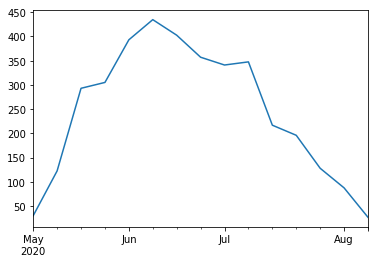

In [20]:
excess_deaths['CPT'].plot()

In [29]:
# get rid of no-hospital multiplier? 
# use this later .. to change parameters during simulation? 
# with open('config_ct.json', 'w') as outfile:
#     json.dump(ct_param_file, outfile)

## 3. sample uncertain parameters

In [30]:
population_size = 500

In [31]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
# with open('hypercube.txt', 'w') as f:
#     json.dump(latin_hyper_cube, f)
# transform the first four parameters into ints 
for pars in latin_hyper_cube:
    for p in range(4): 
        pars[p] =  round(int(pars[p]))

## 4 for each pair of uncertain parameters, estimate R0 and simulate the model and output recoveries

In [33]:
def distr_model_performance(input_params):
    """
    Simple function calibrate uncertain model parameters
    :param input_parameters: list of input parameters
    :return: cost
    """
    R0 = input_params[0]
    
    # run model with parameters.
    infected, sim_dead = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=R0)
   
    m_sim = {'dead': sim_dead}
    m_emp = {'dead': 3680.69}#3680.6929047825934} # 2719.0

    # calculate the cost
    cost = cost_function(m_emp, m_sim)#quadratic_loss_function(stylized_facts_sim, empirical_moments, W)
    return cost

In [34]:
deaths = []
recoveries = []
r_naughts = []
for initial_params in latin_hyper_cube:
    ct_param_file = {}
    for idx, par in enumerate(initial_params):
        ct_param_file[problem['names'][idx]] = par

    with open('config_sensitivity_ode.json', 'w') as outfile:
         json.dump(ct_param_file, outfile)
    
    # left right bounds + initial R_0 for optimizer 
    LB = 1.1
    UB = 5.2
    initial_r_zero = 1.61

    output = constrNM(distr_model_performance, [initial_r_zero], [LB], [UB], maxiter=5, full_output=True)
    optimal_r_zero = output['xopt'][0]
    #print('optimal R0: ', optimal_r_zero)
    recovered, dead = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=optimal_r_zero)
    #print('recovered: ', recovered, ' dead: ', dead)
    deaths.append(dead)
    recoveries.append(recovered)
    r_naughts.append(optimal_r_zero)

In [35]:
population = 4617560

In [47]:
np.mean(recoveries) 

2264417.192

In [36]:
cf = confidence_interval(recoveries, np.mean(recoveries))
[x / population for x in cf]

[0.4830719672243729, 0.4977132058973623]

In [48]:
np.mean(recoveries) / population

0.4903925865608676

In [38]:
np.max(recoveries) / population

0.7044772563864898

In [39]:
np.min(recoveries) / population

0.31868692556241823

In [42]:
relative_recoveries = [x / population for x in recoveries]
relative_recoveries_excess = [x / population for x in recoveries]

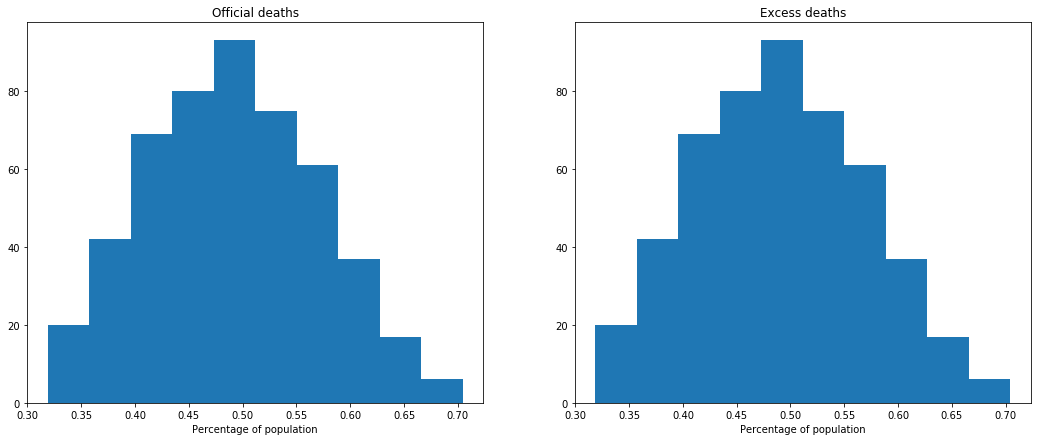

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

ax1.hist(relative_recoveries)
ax1.set_title('Official deaths')
ax1.set_xlabel('Percentage of population')

ax2.hist(relative_recoveries_excess)
ax2.set_title('Excess deaths')
ax2.set_xlabel('Percentage of population')

fig.savefig('immunity_distribution.png')

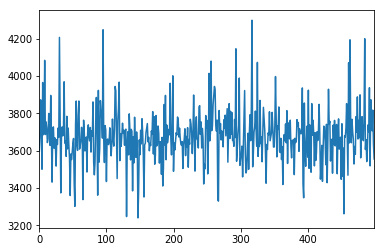

In [46]:
pd.Series(deaths).plot()

In [98]:
# for parameters ... 
initial_params = latin_hyper_cube[0]
initial_params

[3, 9, 7, 15, 0.6319676502823011, 1.1536953439864268, 0.7578781953855922]

In [99]:
ct_param_file = {}
for idx, par in enumerate(initial_params):
    ct_param_file[problem['names'][idx]] = par

with open('config_sensitivity_ode.json', 'w') as outfile:
     json.dump(ct_param_file, outfile)
        
#ct_param_file

In [102]:
# left right bounds + initial R_0 for optimizer 
LB = 1.0
UB = 1.80
initial_r_zero = 1.61

output = constrNM(distr_model_performance, [initial_r_zero], [LB], [UB], maxiter=6, full_output=True)
optimal_r_zero = output['xopt'][0]
print('optimal R0: ', optimal_r_zero)
recovered, dead = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=optimal_r_zero)
print('recovered: ', recovered, ' dead: ', dead)

optimal R0:  1.4330610250546743
recovered:  1582775.0  dead:  3573.0


### Optimize with Nead Mealder

1. get empirical moments 
2. formulate left_bound and right bound for parameter
3. calculate cost of a simulation using quadratic loss function
4. use constrNM(model_performance, init_parameters, LB, UB, maxiter=10, full_output=True) 

In [57]:
# 1 empirical moment
sum_death_ct

3680.6929047825934

In [58]:
# 2 formulate left and right bound
LB = 1.25
UB = 1.70
# 3 formulate initial parameter
initial_r_zero = 1.61
# 4 calculate cost using quadratic loss function 
m_sim = {'dead': 3403.0}
m_emp = {'dead':sum_death_ct}

In [65]:
output = constrNM(distr_model_performance, [initial_r_zero], [LB], [UB], maxiter=10, full_output=True)

In [66]:
optimal_r_zero = output['xopt'][0]
optimal_r_zero

1.6184858424119966

In [67]:
infected, dead = demodel(input_folder_path='cape_town', output_folder_path='output_data/cape_town', r_zero=optimal_r_zero)

In [68]:
dead

3681.0

## 5. use some estimation technique to estimate the most likely % of recoveries